In [1]:
import pandas

import pygsheets
import numpy
import scipy
import re

import matplotlib
import matplotlib.pyplot as mp
import matplotlib.cm

import textwrap
import seaborn

## define colors used in bars

In [2]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
tracker_operating = sel_cmap(0.999)
tracker_construction = sel_cmap(0.8)
tracker_proposed = sel_cmap(0.6)
tracker_shelved = sel_cmap(0.4)
tracker_cancelled = sel_cmap(0.2)

# import data directly from google sheets

In [3]:
credentials_directory = '/Users/baird/Dropbox/_google-api/'
gc = pygsheets.authorize(service_account_env_var='GDRIVE_API_CREDENTIALS')
spreadsheet = gc.open_by_key('1foPLE6K-uqFlaYgLPAUxzeXfDO5wOOqE7tibNHeqTek')

#spreadsheet[1] "Gas Pipelines" tab is the second index
gas_pipes = spreadsheet.worksheet('title','Gas pipelines').get_as_df(start='A2')
oil_pipes = spreadsheet.worksheet('title', 'Oil/NGL pipelines').get_as_df(start='A2')

pipes_df_orig = pandas.concat([oil_pipes, gas_pipes], ignore_index=True)

#get country ratios sheet
country_ratios_df = spreadsheet.worksheet('title', 'Country ratios by pipeline').get_as_df()

In [4]:
owners_df_orig = spreadsheet.worksheet('title', 'Pipeline operators/owners (1/3)').get_as_df(start='A2')
owners_df_orig = owners_df_orig.loc[owners_df_orig.ProjectID!='']
owners_df_orig = owners_df_orig.loc[owners_df_orig.Wiki!='']
owners_df = owners_df_orig.replace('',numpy.nan)

owner_parent_links_df = spreadsheet.worksheet('title', 'Owner–parent relationships (2/3)').get_as_df(start='A2')
# only keep the owners with a checked relationship
owner_parent_links_df = owner_parent_links_df.loc[owner_parent_links_df['Parent–Owner Relationship Checked?']=='yes']
owner_parent_links_df.replace('',numpy.nan,inplace=True)

parents_df = spreadsheet.worksheet('title', 'Parent metadata (3/3)').get_as_df(start='A2')
parents_df = parents_df.loc[parents_df.Parent!='']

owners_df.set_index('ProjectID', inplace=True)
owner_parent_links_df.set_index('Owner', inplace=True)
parents_df.set_index('Parent', inplace=True)

# ****************************************

## create list of owner and parent column names
owner_pct_col_names = []
owner_col_names = []

parent_pct_col_names = []
parent_col_names = []

for num in range(1,11+1):
    owner_pct_col = f'Owner{num}%'
    owner_pct_col_names.append(owner_pct_col)
    
    owner_col = f'Owner{num}'
    owner_col_names.append(owner_col)
    
    parent_pct_col = f'Parent{num}%'
    parent_pct_col_names.append(parent_pct_col)
    
    parent_col = f'Parent{num}'
    parent_col_names.append(parent_col)

# ****************************************
## fill in missing parent info by borrowing owner info
owners_FULL_set = owners_df[owner_col_names].stack().dropna().unique().tolist() # from owners_df
owners_researched_set = list(set(owner_parent_links_df.index.to_list()))#+['Unknown'] # only existing owners, plus 'Unknown'
owners_diff = list(set(owners_FULL_set)-set(owners_researched_set))
owners_diff.append('Unknown')

# update owner_parent_links_df with these extra owners
owner_parent_links_df = pandas.concat([owner_parent_links_df, pandas.DataFrame(index=owners_diff, columns=owner_parent_links_df.columns)])
owner_parent_links_df['Parent1'].loc[owners_diff] = owners_diff
owner_parent_links_df['Parent1%'].loc[owners_diff] = '100.00%'

# ****************************************
# update parents_df with these as well
# note countries will be unknkown...
parents_set = list(set(parents_df.index.to_list()))
parents_diff = list(set(owners_diff)-set(parents_set))
parents_diff.append('Unknown')
parents_df = pandas.concat([parents_df, pandas.DataFrame(numpy.nan, index=parents_diff, columns=parents_df.columns)])
parents_df.loc[parents_diff,'ParentHQCountry'] = 'Unknown'

## replace "--" with NaN, removing empty rows

the dataset is structured to have -- wherever there's a lookup value that doesn't exist; replacing it with NaN (numpy.nan) allows pandas to treat it as a null value, which makes calculations much easier

In [5]:
# replace -- entries with NaN
pipes_df_orig = pipes_df_orig.replace('--', numpy.nan)
pipes_df_orig = pipes_df_orig[pipes_df_orig['PipelineName']!='']
pipes_df_orig = pipes_df_orig[pipes_df_orig['Wiki']!='']
country_ratios_df.replace('--', numpy.nan, inplace=True)

# km by country, km by region calculations

In [6]:
status_list = ['Proposed', 'Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']
country_list = sorted(list(set(country_ratios_df['Country'])))
region_list = sorted(list(set(country_ratios_df['Region'])))

In [7]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

km_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
km_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    km_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
km_by_region_df = km_by_region_df.fillna(0)
km_by_country_df = km_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [8]:
km_by_region_df['Proposed+Construction'] = km_by_region_df[['Proposed','Construction']].sum(axis=1)
km_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_region_df = km_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [9]:
km_by_country_df['Proposed+Construction'] = km_by_country_df[['Proposed','Construction']].sum(axis=1)
km_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
km_by_country_df = km_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
km_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

# projects by country, by region

In [10]:
country_ratios_gas_df = country_ratios_df[country_ratios_df['Fuel']=='Gas']

num_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
num_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_country_df[status] = country_ratios_gas_df_status.groupby('ProjectID')['MergedKmByCountry'].sum()

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df['Status']==status]
    num_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['MergedKmByCountry'].sum()

# # fill NaN with 0.0
num_by_region_df = num_by_region_df.fillna(0)
num_by_country_df = num_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


# numbers of pipes finished in a given year

In [12]:
# count pipelines that are already operating
pipes_started = pipes_df_orig.copy()
pipes_started['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started = pipes_started[(pipes_started['Status'].isin(['Operating'])) &
                              (pipes_started['Fuel']=='Gas')]
pipes_started_sum = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()

In [13]:
# count km of pipeline for each start year
pipes_started_startyear = pipes_df_orig.copy()
pipes_started_startyear['StartYearEarliest'].replace(numpy.nan,'',inplace=True)
pipes_started_startyear = pipes_started_startyear[(pipes_started_startyear['Status'].isin(['Operating'])) &
                              (pipes_started_startyear['Fuel']=='Gas')]
#pipes_started_startyear_sum = pipes_started_startyear.groupby('StartYearLatest')['LengthMergedKm'].sum()

In [14]:
# indev pipelines = Proposed or Construction or Shelved
pipes_indev = pipes_df_orig.copy()
pipes_indev = pipes_indev.loc[(pipes_indev.Fuel=='Gas')&
                              (pipes_indev.Status.isin(['Proposed','Construction','Shelved']))].groupby('Status')['LengthMergedKm'].sum()
#pipes_indev = pipes_indev.loc[(pipes_indev.StartYearEarliest>2022)|
#                              (pipes_indev.StartYearEarliest.isna())].groupby('Status')['LengthMergedKm'].sum()

In [15]:
pipes_indev_to2030 = pipes_df_orig.copy()
pipes_indev_to2030 = pipes_indev_to2030.loc[(pipes_indev_to2030['Fuel']=='Gas') &
                                        (pipes_indev_to2030['Status'].isin(['Proposed','Construction','Shelved'])) &
                                        (pipes_indev_to2030['StartYearEarliest'].isin(list(range(2023,2031))))]
pipes_indev_to2030 = pipes_indev_to2030.groupby('Status')['LengthMergedKm'].sum()


In [16]:
pipes_indev_startyear = pipes_df_orig.copy()
pipes_indev_startyear = pipes_indev_startyear[(pipes_indev_startyear['Status'].isin(['Proposed','Construction','Shelved'])) &
                                              (pipes_indev_startyear['Fuel']=='Gas')]
pipes_indev_startyear = pipes_indev_startyear.groupby(['Status','StartYearEarliest'], dropna=False)['LengthMergedKm'].sum(min_count=1)

In [17]:
pipes_indev_startyear.unstack()

StartYearEarliest,2018.0,2019.0,2020.0,2021.0,2022.0,2023.0,2024.0,2025.0,2026.0,2027.0,2028.0,2029.0,2030.0,2034.0,2035.0,2046.0,NaN
Status,,,,,,,,,,,,,,,,,
Construction,873.0,NaN,NaN,34.76,28031.12,13428.02,5100.24,1773.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17579.25
Proposed,NaN,450.0,38.0,0.00,5110.72,8824.17,10180.17,9767.77,3499.17,3576.66,5323.74,942.0,5855.63,315.0,110.0,5660.0,80892.58
Shelved,NaN,221.7,1100.7,5159.62,3588.37,3353.45,1308.38,1169.99,NaN,150.00,11.00,135.0,NaN,NaN,NaN,NaN,21026.02


## Fig 2 - 2023–2030, go back to 2008

In [18]:
pandas.DataFrame(pipes_started_sum).to_excel('saved-tables/pipelines-operating-km-by-start-year.xlsx')

pandas.DataFrame(pipes_indev_startyear).unstack().replace(numpy.nan,0).to_excel('saved-tables/pipelines-indev-km-by-start-year.xlsx')

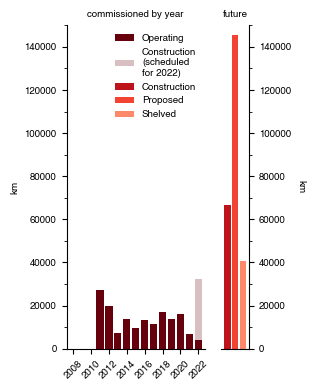

In [19]:
font_size = 7

ytop = 150000
ytop2 = 150000

fig = mp.figure(figsize=(3.25,4))

widths=[15,3]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03
ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)
ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,3.75)
xvals = [1,2,3]

colors = [tracker_construction, tracker_proposed, tracker_shelved]
status = ['Construction', 'Proposed', 'Shelved']
ax2_list = []
for x,c,s in zip(xvals,colors,status):
    if s in ['Proposed','Shelved']:
        ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
                 color=c, label=s))
    else:
        ax2_list.append(ax2.bar(x, pipes_indev[s],
                 color=c, label=s))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])


ax2.yaxis.tick_right()
ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
ax2.yaxis.set_label_position('right')

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False)

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout()#w_pad=0.05)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022.pdf', bbox_inches='tight', transparent=True)

## alt for David

In [20]:
pipes_indev

Status
Construction     66819.39
Proposed        140545.61
Shelved          37224.23
Name: LengthMergedKm, dtype: float64

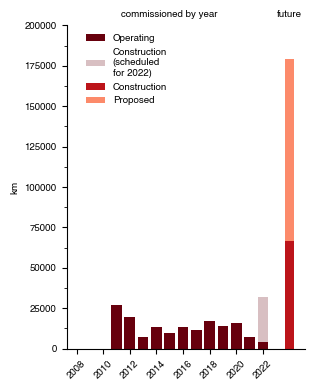

In [21]:
font_size = 7

ytop = 200000
ytop2 = 200000

fig = mp.figure(figsize=(3.25,4))

widths=[15,2.25]
spec = fig.add_gridspec(ncols=2, nrows=1, width_ratios=widths)

ax = fig.add_subplot(spec[0,0])

ax.bar(pipes_started_sum.index.values[-15:-1], pipes_started_sum.values[-15:-1],
       color=tracker_operating, label='Operating') # color=solar_base03

ax.bar(2022,pipes_indev_startyear['Construction',2022],
       label='Construction\n(scheduled\nfor 2022)', bottom=pipes_started_sum.loc[2022], 
       facecolor=tracker_operating, alpha=0.25)

ax.tick_params(labelsize=font_size)
ax.tick_params('x', rotation=45)
ax.set_ylabel('km', size=font_size)

ax.set_xlim(2007.25, 2022.75)
ax.set_ylim(0, ytop)

ax.xaxis.set_major_locator(matplotlib.ticker.MaxNLocator(integer=True))

ax2 = fig.add_subplot(spec[0,1])
ax2.set_ylim(0, ytop2)
ax2.set_xlim(0.25,2.75)
xvals = [1.5]

colors = [tracker_construction, tracker_proposed]#, tracker_shelved]
status = ['Construction', 'Proposed']#, 'Shelved']
ax2_list = []
# for x,c,s in zip(xvals,colors,status):
#     if s in ['Proposed','Shelved']:
#         ax2_list.append(ax2.bar(x, pipes_indev[s]+pipes_indev_startyear[s,2022],
#                  color=c, label=s))
#     else:
#         ax2_list.append(ax2.bar(x, pipes_indev[s],
#                  color=c, label=s))
ax2_list.append(ax2.bar(xvals[0], pipes_indev['Construction'],
                 color=tracker_construction, label='Construction'))

ax2_list.append(ax2.bar(xvals[0], pipes_indev['Proposed']-pipes_indev_startyear['Construction',2022],
                        bottom=pipes_indev['Construction'],
                 color=tracker_shelved, label='Proposed'))

ax_h, ax_l = ax.get_legend_handles_labels()
ax2_h, ax2_l = ax2.get_legend_handles_labels()

ax2.set_xticklabels([])
ax2.tick_params(labelsize=font_size)
ax2.set_xticks([])

#ax2.yaxis.tick_right()
#ax2.set_ylabel('km', fontsize=font_size, rotation=-90, labelpad=10)
#ax2.yaxis.set_label_position('right')
ax2.set_yticks([])

ax.legend(handles=ax_h+ax2_h, fontsize=font_size, frameon=False, 
          loc='upper left', bbox_to_anchor=[0.05,1])

axpos = ax.get_position()
ax2pos = ax2.get_position()

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax2.spines['left'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
#ax2.spines['right'].set_visible(False)

ax.set_title('commissioned by year', fontsize=font_size)
ax2.set_title('future', fontsize=font_size)

fig.tight_layout(w_pad=0)

ax.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))
#ax2.yaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))

mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022-alt.png', bbox_inches='tight', transparent=True, dpi=600)
mp.savefig('saved-figures/gas-pipelines_km-by-start-year-backto2008-with-2022-alt.pdf', bbox_inches='tight', transparent=True)

In [22]:
pipes_indev

Status
Construction     66819.39
Proposed        140545.61
Shelved          37224.23
Name: LengthMergedKm, dtype: float64

## percent pipelines with start date (sanity check)

In [23]:
pipes_scratch = pipes_df_orig.copy()
pipes_scratch = pipes_scratch[(pipes_scratch['Fuel']=='Gas') &
                              (pipes_scratch['Status'].isin(['Proposed','Construction','Shelved']))]

In [24]:
pipes_scratch[~pipes_scratch['StartYearEarliest'].isnull()]['StartYearEarliest'].count()/pipes_scratch.shape[0]


0.5717948717948718

## regional pipelines started in given year

In [25]:
years_array = numpy.arange( float(pipes_df_orig['StartYearEarliest'].min()), float(pipes_df_orig['StartYearEarliest'].max())+1)
regions_startyear_sums_df = pandas.DataFrame(numpy.nan, index=years_array, columns=region_list)

In [26]:
#pipes_started = pipes_df.copy()[(pipes_df['Status'].isin(['Operating'])) & pipes_df['Fuel']=='Gas']
#pipes_started_sum = pipes_started.groupby('StartYearLatest')['LengthMergedKm'].sum()

for region in region_list:
    pipes_started = pipes_df_orig.copy()[(pipes_df_orig['Status'].isin(['Operating','Retired','Idle'])) & 
                                    (pipes_df_orig['Fuel']=='Gas')]
    pipes_started = pipes_started[pipes_started['StartRegion']==region]
    pipes_started_sum_up = pipes_started.groupby('StartYearEarliest')['LengthMergedKm'].sum()
    
    regions_startyear_sums_df[region] = pipes_started_sum_up

In [27]:
if len(region_list)!=10:
    region_list = region_list[2:]

## plot pie chart of regional values

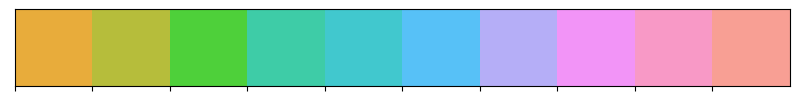

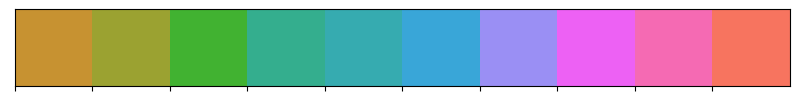

In [28]:
# mess with some color pallettes
#seaborn.color_palette('husl', 10)
seaborn.palplot(seaborn.husl_palette(10, s=0.9, l=0.75, h=0.15))
seaborn.palplot(seaborn.husl_palette(10, h=0.15))

cmap_dark = seaborn.husl_palette(10, h=0.15, l=0.4, s=0.8, as_cmap=True)
cmap_light = seaborn.husl_palette(10, h=0.15, s=1, as_cmap=True)

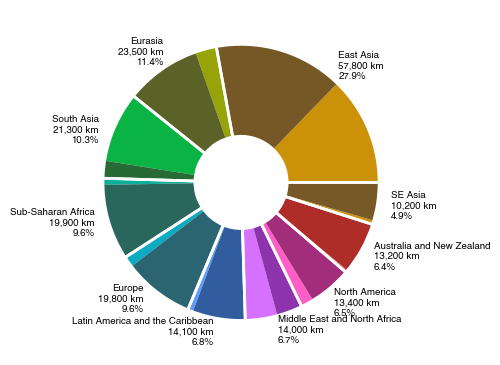

In [29]:
font_size=7

fig = mp.figure(figsize=(5,5))
ax = fig.add_subplot(111)

nwedges = region_list.__len__()
region_order = km_by_region_df.index[:nwedges]

pie_vals = km_by_region_df.loc[region_order]['Proposed+Construction'].values
pie_labels = km_by_region_df.index
pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-2)):,} km')
pie_labels_perc = (km_by_region_df.loc[region_order]['Proposed+Construction'] / 
                   km_by_region_df.loc[region_order]['Proposed+Construction'].sum() * 100.).apply(lambda x: f'\n{x:.1f}%')

# ****************************************
pie_vals_separated = km_by_region_df.loc[region_order][['Construction','Proposed']].values.flatten()
#pie_labels_separated = numpy.array(list(zip(km_by_region_df.index[:-1],km_by_region_df.index[:-1]))).flatten()
#pie_labels_km = km_by_region_df.loc[region_order]['Proposed+Construction'].apply(lambda x: f'\n{int(round(x,-3)):,} km')

nwedges_separated = 20
cmap_light_10 = cmap_light(numpy.linspace(0,1,nwedges))
cmap_dark_10 = cmap_dark(numpy.linspace(0,1,nwedges))

pie_labels = [i+j+k for i,j,k in zip(pie_labels, pie_labels_km, pie_labels_perc)]
pie_width = 0.666

# ****************************************
# size=0.3
ax.pie(pie_vals_separated, 
       #labels=pie_labels,
       #radius=1-size,
       colors=numpy.hstack((cmap_light_10, cmap_dark_10)).reshape(20,-1),
       wedgeprops=dict(width=pie_width),
       textprops={'fontsize': font_size})
ax.pie(pie_vals, 
       labels=pie_labels,
       #radius=1,
       #bottom=0.25,
       colors=None,#cmap(numpy.linspace(0,1,pie_vals.size))[::-1],
       wedgeprops=dict(edgecolor='1', facecolor='None', linewidth=2, width=pie_width),
       textprops={'fontsize': font_size})


ax.tick_params(labelsize=font_size)

fig.tight_layout()

mp.savefig('saved-figures/gas-pipelines_pie-graph-country-pipelines-km.pdf', bbox_inches='tight', transparent=True)

mp.savefig('saved-figures/gas-pipelines_pie-graph-country-pipelines-km.png', 
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

# top 20 countries proposed+construction

In [30]:
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 10))  # outward by 10 points
        else:
            spine.set_color('none')  # don't draw spine

    # turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # no yaxis ticks
        ax.yaxis.set_ticks([])

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # no xaxis ticks
        ax.xaxis.set_ticks([])

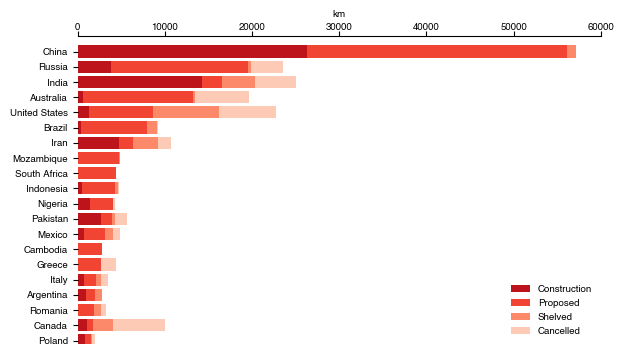

In [31]:
font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_construction,#solar_orange, 
        label='Construction')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=tracker_proposed,#solar_yellow, 
        label='Proposed')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Shelved'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction']].sum(axis=1).values, 
        facecolor=tracker_shelved,#'0.75', 
        label='Shelved')

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Cancelled'].values, 
        left=km_by_country_df.loc[country_order][['Proposed','Construction','Shelved']].sum(axis=1).values, 
        facecolor=tracker_cancelled,#'0.9', 
        label='Cancelled')

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/gas-pipelines_top-20-countries.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/gas-pipelines_top-20-countries.pdf',
          bbox_inches='tight', 
          transparent=True)

# top 20 without cancelled and shelved bars

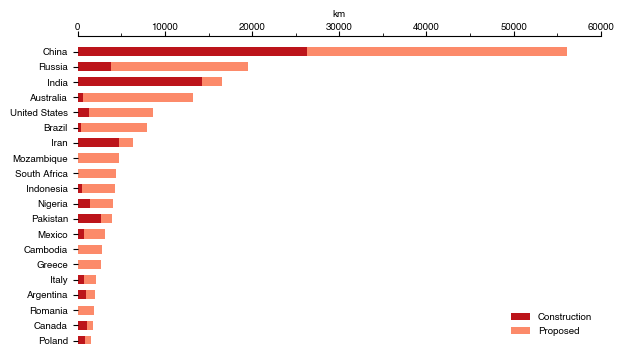

In [32]:
sel_cmap = matplotlib.cm.get_cmap('Reds')
#tracker_operating = sel_cmap(0.999)
#tracker_construction = sel_cmap(0.8)
#tracker_proposed = sel_cmap(0.6)
#tracker_shelved = sel_cmap(0.4)
#tracker_cancelled = sel_cmap(0.2)

font_size = 7
fig = mp.figure(figsize=(6.75,4))
nbars=20

country_order = km_by_country_df.index[:nbars][::-1]

ax = fig.add_subplot(111)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.8),
        label='Construction', height=0.6)

ax.barh(numpy.arange(nbars), 
        km_by_country_df.loc[country_order]['Proposed'].values, 
        left=km_by_country_df.loc[country_order]['Construction'].values, 
        facecolor=sel_cmap(0.4),
        label='Proposed', height=0.6)

ax.set_yticks(numpy.arange(nbars))
ax.set_yticklabels(km_by_country_df.index[:nbars][::-1])
ax.tick_params(labelsize=font_size)
ax.tick_params('x', pad=0)
ax.set_xlim(0,60000)
#ax.set_ylim(-.75,19.75)
ax.set_ylim(-.25,20)
ax.set_xlabel('km', size=font_size)#, labelpad=10)
ax.xaxis.set_ticks_position('top')
ax.xaxis.set_label_position('top')

ax.legend(fontsize=font_size, frameon=False, loc='lower right')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

#ax.xaxis.grid(True, which='minor')
ax.xaxis.set_minor_locator(matplotlib.ticker.AutoMinorLocator(2))


#mp.savefig('saved-figures/oil-pipelines_top-20-countries.pdf', bbox_inches='tight', transparent=True)

#adjust_spines(ax, ['top'])
    
mp.savefig('saved-figures/gas-pipelines_top-20-countries-no-cancelled-shelved.png',
          bbox_inches='tight', 
          transparent=True,
          dpi=600)

mp.savefig('saved-figures/gas-pipelines_top-20-countries-no-cancelled-shelved.pdf',
          bbox_inches='tight', 
          transparent=True)

In [33]:
# ratio of China to India (how many times larger is km of Chinese pipelines than India?)
km_by_country_df.loc['China']['Proposed+Construction']/km_by_country_df.loc['India']['Proposed+Construction']

3.4025712154059584

# parent analysis

In [34]:
owner_parent_calculations_df = pandas.DataFrame()
# needs country, km in each country columns as well

for idx,row in country_ratios_df.loc[(country_ratios_df.Fuel=='Gas')&(country_ratios_df.Status.isin(['Proposed','Construction']))].iterrows():
    parent_string = pipes_df_orig.loc[pipes_df_orig.ProjectID==row.ProjectID].Parent.values[0]
    #print(parent_string)
    parent_list = re.sub(' \[.*?\]', '', parent_string).split('; ') # all entries must have a Owner [%] syntax
    percent_list = [float(i.rstrip('%'))/100. for i in re.findall('\\d+(?:\\.\\d+)?%', parent_string)]

    if parent_list.__len__()!=percent_list.__len__():
        if percent_list==[]:
            percent_list = [1/parent_list.__len__() for i in parent_list]
        else:
            nmissing = parent_list.__len__()-percent_list.__len__()
            # distribute nans evenly
            total = numpy.nansum(percent_list)
            leftover = 1-total
            percent_list += [leftover/nmissing]*nmissing

    # for when database isn't completely filled in for owners:
    for p_idx,parent in enumerate(parent_list):
        if parent not in parents_df.index.to_list():
            parents_df.loc[parent,'ParentHQCountry']='Unknown'
        owner_parent_calculations_df = pandas.concat([owner_parent_calculations_df, 
                                                      pandas.DataFrame([{'Parent':parent, 'ProjectID':row.ProjectID, 
                                                                         'FractionOwnership':percent_list[p_idx],
                                                                         'ParentHQCountry':parents_df.loc[parents_df.index==parent]['ParentHQCountry'].values[0],
                                                                         'PipelineCountry':row.Country,
                                                                         'Status':row.Status,
                                                                         'MergedKmByCountry':row.MergedKmByCountry,
                                                                         'MergedKmByPipeline':row.MergedKmByPipeline,
                                                                         'CapacityBOEd':row.CapacityBOEd}])])

owner_parent_calculations_df['KmOwnershipByCountry'] = owner_parent_calculations_df.FractionOwnership*owner_parent_calculations_df.MergedKmByCountry

## print out leading parent companies

In [35]:
parent_country_km_df = \
owner_parent_calculations_df.loc[#(owner_parent_calculations_df.PipelineCountry.isin(region_df_touse.Country.tolist()))&
                                 (owner_parent_calculations_df.Status.isin(['Proposed','Construction']))]

parent_country_km_df_table = pandas.DataFrame(index=parent_country_km_df.Parent.unique().tolist(),
                                             columns=['Pipeline Country Locations','Owner Headquarters Country',
                                                      'Proposed','Construction','In Development (Proposed + Construction)','ProjectIDs'])

parent_country_km_df_table['Proposed'] = parent_country_km_df.loc[parent_country_km_df.Status=='Proposed'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]
parent_country_km_df_table['Construction'] = parent_country_km_df.loc[parent_country_km_df.Status=='Construction'].groupby('Parent').sum('KmOwnershipByCountry')[['KmOwnershipByCountry']]

In [38]:
pandas.options.display.max_colwidth = 500

country_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).PipelineCountry.agg(lambda x: ', '.join(x.unique())))
projectid_agg_df = pandas.DataFrame(owner_parent_calculations_df.groupby(['Parent']).ProjectID.agg(lambda x: ', '.join(x.unique())))
parent_country_km_df_table['Pipeline Country Locations'] = country_agg_df.PipelineCountry
parent_country_km_df_table['Number of Projects'] = owner_parent_calculations_df.groupby(['Parent']).ProjectID.count()
parent_country_km_df_table['ProjectIDs'] = projectid_agg_df.ProjectID
parent_country_km_df_table['Owner Headquarters Country'] = parent_country_km_df.drop_duplicates('Parent').set_index('Parent').ParentHQCountry
parent_country_km_df_table['In Development (Proposed + Construction)'] = parent_country_km_df_table[['Proposed','Construction']].sum(axis=1, min_count=0)
parent_country_km_df_table.loc[~parent_country_km_df_table.index.isin(['Not in database','Unknown'])].replace(numpy.nan, '').sort_values('In Development (Proposed + Construction)', ascending=False)[:20]

,Pipeline Country Locations,Owner Headquarters Country,Proposed,Construction,In Development (Proposed + Construction),ProjectIDs,Number of Projects
Gazprom,"Mongolia, China, Russia, Bulgaria, Serbia, Iran, Pakistan, Kazakhstan, Kyrgyzstan",Russia,16425.16,3728.866667,20154.026667,"P0734, P1336, P2287, P2313, P2327, P2346, P2353, P2425, P2437, P2707, P3174, P3176, P3208, P3369, P3370, P3604, P3607, P3725, P3894, P3895, P3971, P3972, P3973, P3974, P3976, P3977, P3978, P3979, P3980, P3981, P3982, P3990, P3991, P3992, P3996, P3997, P3998, P3999, P4012, P4013, P4044, P4056, P4063, P4076, P4077, P4078, P4080, P4081, P4083, P4085, P4092, P4093, P4094, P4095, P4096, P4109, P4110, P4111, P4112, P4130, P4131, P4132, P4142, P4143, P4144, P4149, P4150, P4156, P4166, P4167, P4171,...",81
PipeChina,China,China,8607.64,3727.76,12335.400000,"P1385, P1386, P1390, P1413, P1521, P2123, P2167, P2174, P3254, P3256, P3257, P3258, P3259, P3261, P3262, P3263, P3265, P3267, P3409, P3411, P3412, P3413, P3414, P3415, P3571, P3572",26
Sinopec 中国石油化工股份有限公司,China,Unknown,1646.5,8730.95,10377.450000,"P1387, P1419, P1516, P1519, P2132, P2171, P3245, P3246",8
GAIL (India) Limited,India,India,890.0,6821.48,7711.480000,"P0929, P0932, P0954, P1309, P2215, P2216, P2746, P2752, P3906, P3912",10
Nigerian National Petroleum Corporation,"Nigeria, Niger, Algeria, Liberia, Senegal, Guinea-Bissau, Mauritania, Côte d'Ivoire, Western Sahara, Sierra Leone, Morocco, Guinea, Spain, The Gambia, Ghana, Joint regime area (Senegal/Guinea Bissau)",Nigeria,4927.638333,1427.0,6354.638333,"P0460, P0463, P0488, P1313, P4185",20
Iran Ministry of Petroleum,"Iran, Pakistan, Oman",Iran,400.0,5875.0,6275.000000,"P0441, P0448, P0452, P2225",6
China National Petroleum Corporation,"Malaysia, China, South Africa, Mozambique, Russia",China,1604.74,3820.86,5425.600000,"P1067, P1387, P2119, P2148, P2179, P2249, P3219, P3598",10
Transnet,"Namibia, South Africa",South Africa,3949.19,,3949.190000,"P2254, P2469, P2470, P2471, P2472, P2473, P2474, P3337, P3338, P3339",11
"Guizhou Wujiang Energy Group Co., Ltd. 贵州乌江能源集团有限责任公司",China,Unknown,,3147.33,3147.330000,P3581,1
Moroccan National Board of Hydrocarbons and Mines,"Liberia, Senegal, Guinea-Bissau, Mauritania, Côte d'Ivoire, Western Sahara, Sierra Leone, Morocco, Guinea, Spain, The Gambia, Ghana, Joint regime area (Senegal/Guinea Bissau)",Morocco,2865.635,,2865.635000,P0463,14


### how many of the projects for each owner do we have capacity data for? (add fraction)

## emissions estimates

In [39]:
# kuhne paper
co2_rate = 152.789 # number is 152,789 tCO2/year emissions per kilobarrel per day, divide by 1000 to get per bpd (bpd=BOEd)

### total emissions globally (known capacity is at about 67%)

### count fraction of available capacity information

count

In [40]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
pipes_df_subset.loc[~pipes_df_subset['CapacityBcm/y'].isna()].groupby('StartRegion')['CapacityBOEd'].size()
#pipes_df_subset.groupby('StartRegion')['CapacityBcm/y'].size()

StartRegion
Australia and New Zealand           23
East Asia                           92
Eurasia                             62
Europe                              58
Latin America and the Caribbean     30
Middle East and North Africa        10
North America                      103
SE Asia                             11
South Asia                          29
Sub-Saharan Africa                   6
Name: CapacityBOEd, dtype: int64

fraction

In [41]:
pandas.options.display.float_format = '{:,.3f}'.format
pandas.DataFrame(pipes_df_subset.loc[
    ~pipes_df_subset['CapacityBcm/y'].isna()].groupby(
    'StartRegion')['CapacityBcm/y'].size()/pipes_df_subset.groupby(
    'StartRegion')['CapacityBOEd'].size()).sort_values(by=0, ascending=False)

,0
StartRegion,
Latin America and the Caribbean,0.938
Australia and New Zealand,0.821
North America,0.730
South Asia,0.725
Eurasia,0.667
East Asia,0.575
Middle East and North Africa,0.476
Europe,0.408
SE Asia,0.407


In [42]:
median_capacity = pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()

In [43]:
abs_dist_from_med_capacity = abs(pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y']-
                                 pipes_df_orig.loc[pipes_df_orig.Fuel=='Gas']['CapacityBcm/y'].median()).median()

In [44]:
pipes_df_orig['CapacityBcm/y'].mean()

248.86364987613544

In [45]:
pipes_df_orig['CapacityBcm/y'].std()

636.0124305531024

In [46]:
print(median_capacity)
print(abs_dist_from_med_capacity)

4.14
3.5399999999999996


median capacity for a pipeline is about 4.14 bcm/y

median abs dist from the median is about 3.5.

# cost estimates (pipeline cost per km)

throwing out any estimates larger than USD 10 million per km for taking regional estimates

In [47]:
# pull out only pipelines that have a KNOWN length AND a cost
country_ratios_with_length_and_cost_df = country_ratios_df.copy()[(country_ratios_df['Fuel']=='Gas') & 
                                    (country_ratios_df['CostUSDPerKm'].notna()) & 
                                    (country_ratios_df['LengthKnownKmByCountry'].notna()) &
                                    (country_ratios_df['LengthKnownKm']!=0) #&
                                    #(country_ratios_df['CostUSDPerKm']<10e6)
                                   ]
#country_ratios_with_length_and_cost_df = country_ratios_with_length_and_cost_df[~country_ratios_with_length_and_cost_df.ProjectID.isin(outliers_projectids)]

### global mean value

In [48]:
country_ratios_with_length_and_cost_df['CostUSDPerKm'].drop_duplicates().mean()

5260666.1350559285

### calculate regional costs

In [49]:
pipes_gas_costs_region_df = pandas.DataFrame(0, index=region_list, columns=['CostUSDPerKm','DataPoints'])#,'NumberOfLengths'])

for region in region_list:
    print(region)
    country_ratios_region_df = country_ratios_with_length_and_cost_df.loc[country_ratios_with_length_and_cost_df['Region']==region,:]
    pipes_gas_costs_region_df.loc[region,'CostUSDPerKm'] = country_ratios_region_df['CostUSDPerKm'].mean()
    pipes_gas_costs_region_df.loc[region,'DataPoints'] = list(set(country_ratios_region_df['ProjectID'])).__len__()


Australia and New Zealand
East Asia
Eurasia
Europe
Latin America and the Caribbean
Middle East and North Africa
North America
SE Asia
South Asia
Sub-Saharan Africa


In [50]:
country_ratios_region_df['CostUSDPerKm'].mean()

3928708.954117647

In [51]:
pandas.options.display.float_format = '{:,.3f}'.format
temp_df = pipes_gas_costs_region_df.copy()
temp_df['CostUSDPerKm'] = temp_df['CostUSDPerKm']/1e6
temp_df.sort_values('CostUSDPerKm', ascending=False)#.loc[region]['CostUSDPerKm']

,CostUSDPerKm,DataPoints
North America,10.284,163
Eurasia,4.115,46
Sub-Saharan Africa,3.929,5
Latin America and the Caribbean,3.503,24
Europe,3.017,114
Middle East and North Africa,2.810,37
SE Asia,2.366,8
East Asia,1.702,55
South Asia,1.663,17
Australia and New Zealand,1.307,10


### calculate country-level costs

# tables etc.

## table for regional totals

In [52]:
if 'Total' in km_by_region_df.index:
    km_by_region_df.drop(index='Total', inplace=True)   
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

else:
    total = km_by_region_df.sum(axis=0)
    total.name='Total'
    km_by_region_df = km_by_region_df.append(total)

km_by_region_df

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_76583/997741405.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_region_df = km_by_region_df.append(total)


,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
East Asia,"31,379.310","26,378.730","57,758.040","2,067.660","1,364.510","92,288.710",0.000,0.000,41.000
Eurasia,"18,370.350","5,153.090","23,523.440",272.690,"5,756.890","129,176.250",0.000,"3,298.310","1,783.240"
South Asia,"4,222.570","17,113.790","21,336.360","6,344.410","6,141.070","29,701.060",0.000,0.000,35.000
Sub-Saharan Africa,"18,355.360","1,582.000","19,937.360","1,626.160",228.960,"7,031.520",0.000,0.000,0.000
Europe,"17,145.970","2,652.190","19,798.160","4,707.470","15,267.440","121,668.450",0.000,"4,735.180",823.060
Latin America and the Caribbean,"12,772.030","1,304.000","14,076.030","2,187.280","1,301.390","39,254.350",0.000,224.000,0.000
Middle East and North Africa,"6,211.810","7,773.200","13,985.010","5,964.340","4,146.270","49,700.910",0.000,"1,107.390",39.280
North America,"10,347.340","3,087.200","13,434.540","10,919.390","13,277.010","421,015.950",331.000,0.000,0.000
Australia and New Zealand,"12,590.050",580.000,"13,170.050",334.280,"6,194.680","30,991.820",0.000,0.000,0.000
SE Asia,"9,222.660",984.300,"10,206.960","2,801.340","1,423.820","16,880.810",0.000,0.000,0.000


## table for km by country

In [53]:
# saves all countries to an Excel file for reference

km_by_country_df.sort_values('Proposed+Construction', ascending=False)

if 'Total' in km_by_country_df.index:
    km_by_country_df.drop(index='Total', inplace=True)   
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

else:
    total = km_by_country_df.sum(axis=0)
    total.name='Total'
    km_by_country_df = km_by_country_df.append(total)

km_by_country_df.to_excel('saved-tables/gas-pipelines-km-by-country.xlsx')

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_76583/3713560636.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  km_by_country_df = km_by_country_df.append(total)


# table for stranded asset calculations

## country-level capex estimates

In [54]:
country_ratios_gas_df.reset_index(drop=True, inplace=True)
country_ratios_gas_df.loc[:,'CostUSDEstimate'] = numpy.nan

for idx,row in country_ratios_gas_df.iterrows():
    # calculate cost
    cntry = row.Country
    region = row.Region
    km_by_cntry = row.LengthKnownKmByCountry
    #print(row.PipelineName)
    country_ratios_gas_df.loc[idx,'CostUSDEstimate'] = pipes_gas_costs_region_df.loc[region, 'CostUSDPerKm'] * km_by_cntry

# replace any known costs now
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()),'CostUSDEstimate'] = \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()), 'LengthKnownKmByCountry'] * \
country_ratios_gas_df.loc[(~country_ratios_gas_df.LengthKnownKmByCountry.isna())&
                      (~country_ratios_gas_df.CostUSDPerKm.isna()), 'CostUSDPerKm']

country_sums_USDBillion_df = pandas.DataFrame(country_ratios_gas_df.loc[(country_ratios_gas_df.Status.isin(['Construction','Proposed']))].groupby('Country')['CostUSDEstimate'].sum(min_count=1)/1e9)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_76583/2612676912.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  country_ratios_gas_df.loc[:,'CostUSDEstimate'] = numpy.nan


In [55]:
capex_by_country_df = pandas.DataFrame(columns=status_list, index=country_list)
capex_by_region_df = pandas.DataFrame(columns=status_list, index=region_list)

print('===country-level calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df.Status==status]
    capex_by_country_df[status] = country_ratios_gas_df_status.groupby('Country')['CostUSDEstimate'].sum()/1e9

print('===regional calculations===')
for status in status_list:
    print(status)
    country_ratios_gas_df_status = country_ratios_gas_df[country_ratios_gas_df.Status==status]
    capex_by_region_df[status] = country_ratios_gas_df_status.groupby('Region')['CostUSDEstimate'].sum()/1e9

# # fill NaN with 0.0
capex_by_region_df = capex_by_region_df.fillna(0)
capex_by_country_df = capex_by_country_df.fillna(0)

===country-level calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired
===regional calculations===
Proposed
Construction
Shelved
Cancelled
Operating
Idle
Mothballed
Retired


In [56]:
capex_by_region_df['Proposed+Construction'] = capex_by_region_df[['Proposed','Construction']].sum(axis=1)
#capex_by_region_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_region_df = capex_by_region_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_region_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [57]:
capex_by_country_df['Proposed+Construction'] = capex_by_country_df[['Proposed','Construction']].sum(axis=1)
#capex_by_country_df.sort_values(by='Proposed+Construction', inplace=True)
capex_by_country_df = capex_by_country_df[['Proposed', 'Construction', 'Proposed+Construction', 'Shelved', 'Cancelled', 'Operating', 'Idle', 'Mothballed', 'Retired']]
capex_by_country_df.sort_values('Proposed+Construction', ascending=False, inplace=True)

In [58]:
if 'Total' in capex_by_region_df.index:
    capex_by_region_df.drop(index='Total', inplace=True)   
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

else:
    total = capex_by_region_df.sum(axis=0)
    total.name='Total'
    capex_by_region_df = capex_by_region_df.append(total)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_76583/2444263024.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_region_df = capex_by_region_df.append(total)


In [59]:
if 'Total' in capex_by_country_df.index:
    capex_by_country_df.drop(index='Total', inplace=True)   
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

else:
    total = capex_by_country_df.sum(axis=0)
    total.name='Total'
    capex_by_country_df = capex_by_country_df.append(total)

/var/folders/h5/nfk59_vx7gg_58myc9jfk7_40000gn/T/ipykernel_76583/3950818690.py:10: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  capex_by_country_df = capex_by_country_df.append(total)


In [60]:
pandas.options.display.float_format = '{:,.1f}'.format
capex_by_region_df

,Proposed,Construction,Proposed+Construction,Shelved,Cancelled,Operating,Idle,Mothballed,Retired
North America,127.2,23.2,150.5,96.9,114.1,"4,011.8",3.4,0.0,0.0
East Asia,46.6,38.7,85.4,2.3,6.1,154.6,0.0,0.0,0.1
Eurasia,54.1,20.9,75.1,1.7,15.6,542.2,0.0,13.6,4.1
Sub-Saharan Africa,55.9,4.0,59.9,0.2,0.2,27.6,0.0,0.0,0.0
Middle East and North Africa,23.4,23.3,46.7,16.6,5.5,133.7,0.0,3.1,0.0
Europe,40.4,5.6,46.0,14.3,48.6,282.8,0.0,13.7,2.5
Latin America and the Caribbean,33.2,3.4,36.6,9.9,4.4,137.5,0.0,0.8,0.0
South Asia,7.5,26.0,33.5,2.0,9.9,46.5,0.0,0.0,0.1
SE Asia,19.2,2.7,21.9,2.4,3.4,39.6,0.0,0.0,0.0
Australia and New Zealand,13.8,0.8,14.5,0.3,7.0,39.7,0.0,0.0,0.0


## print out country-level stranded assets for report discussion

## in-dev for each country in list

In [83]:
#pandas.options.display.float_format = '{:,.1f}'.format
these_countries = ['China','India','Iran','Russia','Pakistan']

for cntry in these_countries:
    print(cntry)
    cntry_region = country_ratios_df.loc[country_ratios_df.Country==cntry]['Region'].to_list()[0]
    print(km_by_country_df.loc[cntry]['Proposed'], ' km proposed')
    print(km_by_country_df.loc[cntry]['Construction'], ' km in construction')
    print(km_by_country_df.loc[cntry]['Proposed+Construction'], ' total km in development')
    print(country_sums_USDBillion_df.loc[cntry], 'USD')  
    print()

China
29814.1  km proposed
26326.93  km in construction
56141.03  total km in development
CostUSDEstimate   82.6
Name: China, dtype: float64 USD

India
2227.92  km proposed
14271.67  km in construction
16499.59  total km in development
CostUSDEstimate   21.7
Name: India, dtype: float64 USD

Iran
1571.41  km proposed
4768.5  km in construction
6339.91  total km in development
CostUSDEstimate   23.6
Name: Iran, dtype: float64 USD

Russia
15784.09  km proposed
3761.9900000000002  km in construction
19546.08  total km in development
CostUSDEstimate   61.5
Name: Russia, dtype: float64 USD

Pakistan
1222.57  km proposed
2692.12  km in construction
3914.6899999999996  total km in development
CostUSDEstimate   10.2
Name: Pakistan, dtype: float64 USD



# numbers for report

## amount already being constructed

In [64]:
# fraction of pipelines under construction compared to all in development
# this number is different from below because it's skipping some pipelines
km_by_country_total = km_by_country_df.sum(axis=0)
km_by_country_total['Construction']/km_by_country_total['Proposed+Construction']

0.3214293383623045

In [65]:
# this fraction is on the full database, rather than only the pipelines that we estimate length for
total['Construction']/total['Proposed+Construction']

0.2608450612139949

## capacity/potential emissions in development globally

In [66]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

0.5389536799999999 million bpd
0.08234619381351999 billion tonnes CO2


In [67]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

0.9606859099999999 million bpd
0.14678223950298996 billion tonnes CO2


In [68]:
pipes_df_subset = pipes_df_orig.loc[(pipes_df_orig.Status.isin(['Construction','Proposed']))&
                                     (pipes_df_orig.Fuel=='Gas')]
cap_sum = pipes_df_subset['CapacityBOEd'].sum()
print(cap_sum / 1e6, 'million bpd')
print(cap_sum * co2_rate / 1e9, 'billion tonnes CO2')

1.49963959 million bpd
0.22912843331650995 billion tonnes CO2


## total number of pipelines in dev

In [69]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))]['LengthMergedKm'].sum()

207365.0

## top 10 pipelines

In [71]:
pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].sort_values(
    'LengthKnownKm', ascending=False)[['PipelineName','LengthKnownKm','CapacityBOEd','Countries','Status','StartYearEarliest','Wiki']].set_index('PipelineName')[:15]



,LengthKnownKm,CapacityBOEd,Countries,Status,StartYearEarliest,Wiki
PipelineName,,,,,,
Xinjiang Coal-to-Gas Pipeline,"8,372.0","13,961.5",China,Construction,"2,022.0",https://www.gem.wiki/Xinjiang_Coal-to-Gas_Pipeline_Project
Nigeria-Morocco Gas Pipeline,"5,660.0","13,961.5","Nigeria, Benin, Togo, Ghana, Côte d'Ivoire, Liberia, Sierra Leone, Guinea, Guinea-Bissau, The Gambia, Senegal, Mauritania, Morocco, Spain",Proposed,"2,046.0",https://www.gem.wiki/Nigeria-Morocco_Gas_Pipeline
Trans-Sahara Gas Pipeline,"4,128.0","13,961.5","Nigeria, Niger, Algeria",Proposed,NaN,https://www.gem.wiki/Trans-Sahara_Gas_Pipeline
West-East Gas Pipeline 5,"3,200.0","20,942.2",China,Proposed,NaN,https://www.gem.wiki/West-East_Gas_Pipeline_5
West-East Gas Pipeline 4,"3,123.0","18,615.3",China,Proposed,NaN,https://www.gem.wiki/West-East_Gas_Pipeline_4
West-East Gas Pipeline,"2,900.0","2,670.5",Australia,Proposed,NaN,https://www.gem.wiki/West-East_Gas_Pipeline
CNGC's Inter-Provincial Gas Pipeline Network,"2,825.0",NaN,Cambodia,Proposed,NaN,https://www.gem.wiki/CNGC%27s_Inter-Provincial_Gas_Pipeline_Network
Iran-Pakistan Pipeline,"2,775.0","3,610.0","Iran, Pakistan",Construction,"2,024.0",https://www.gem.wiki/Iran-Pakistan_Pipeline
Jagdishpur-Haldia-Bokaro-Dhamra Natural Gas Pipeline (JHBDPL),"2,655.0","2,719.7",India,Construction,"2,022.0",https://www.gem.wiki/Jagdishpur-Haldia-Bokaro-Dhamra_Natural_Gas_Pipeline_(JHBDPL)


In [72]:
pandas.DataFrame(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))].groupby(['PipelineName','Status','Wiki'])['LengthKnownKm'].sum(min_count=1).sort_values(ascending=False)[:10])

,,,LengthKnownKm
PipelineName,Status,Wiki,
Xinjiang Coal-to-Gas Pipeline,Construction,https://www.gem.wiki/Xinjiang_Coal-to-Gas_Pipeline_Project,"8,372.0"
Nigeria-Morocco Gas Pipeline,Proposed,https://www.gem.wiki/Nigeria-Morocco_Gas_Pipeline,"5,660.0"
Trans-Sahara Gas Pipeline,Proposed,https://www.gem.wiki/Trans-Sahara_Gas_Pipeline,"4,128.0"
West-East Gas Pipeline 5,Proposed,https://www.gem.wiki/West-East_Gas_Pipeline_5,"3,200.0"
West-East Gas Pipeline 4,Proposed,https://www.gem.wiki/West-East_Gas_Pipeline_4,"3,123.0"
China–Russia East Pipeline,Construction,https://www.gem.wiki/China%E2%80%93Russia_East_Pipeline,"2,934.0"
West-East Gas Pipeline,Proposed,https://www.gem.wiki/West-East_Gas_Pipeline,"2,900.0"
Sichuan–Shanghai Parallel Gas Pipeline,Proposed,https://www.gem.wiki/Sichuan%E2%80%93Shanghai_Parallel_Gas_Pipeline,"2,863.7"
CNGC's Inter-Provincial Gas Pipeline Network,Proposed,https://www.gem.wiki/CNGC%27s_Inter-Provincial_Gas_Pipeline_Network,"2,825.0"


## km of pipeline with 2022, 2023 start years

In [75]:
# for the key points
print(pipes_indev_startyear.loc['Construction',2022],
      pipes_indev_startyear.loc['Construction',2023])

print(pipes_indev_startyear.loc['Proposed',2022],
      pipes_indev_startyear.loc['Proposed',2023])

28031.12 13428.02
5110.72 8824.17


## km of gas pipelines globally in development

note this doesn't match up exactly with regional length calculations, so we've used the regional calculation totals instead (193,365.9)

In [76]:
pipes_df_calc = pipes_df_orig.copy()
pipes_df_calc.replace('--',numpy.nan,inplace=True)
pipes_df_calc[(pipes_df_calc['Status'].isin(['Proposed','Construction'])) &
        (pipes_df_calc['Fuel']=='Gas')]['LengthMergedKm'].sum()

207365.0

In [77]:
regional_km_sums_df = pandas.DataFrame(index=region_list, columns=status_list)

for status in status_list:
    regional_km_sums_df[status] = pipes_df_calc[(pipes_df_calc['Fuel']=='Gas') &
                                                (pipes_df_calc['Status']==status)].groupby('StartRegion')['LengthMergedKm'].sum()

regional_km_sums_df['P+C'] = regional_km_sums_df[['Proposed','Construction']].sum(axis=1)
total_row = regional_km_sums_df.sum(axis=0)
total_row.name = 'Total'
#regional_km_sums_df.append(total_row)

## country shares analysis

In [78]:
country_ratios_df[(country_ratios_df['Status'].isin(['Proposed','Construction'])) &
               (country_ratios_df['Fuel']=='Gas')]['MergedKmByCountry'].sum()

207225.95

## num in dev globally, whether capacity expansions or not

In [79]:
print("capacity expansion projects:",
    pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

print("non-zero length projects:",
      pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (~pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))].shape)

capacity expansion projects: (84, 86)
non-zero length projects: (623, 86)


In [80]:
cr = country_ratios_df.loc[(country_ratios_df.Status.isin(['Construction','Proposed']))&
                      (country_ratios_df.Fuel=='Gas')]

In [81]:
cr.loc[cr.MergedKmByPipeline!=0].groupby('ProjectID')['MergedKmByPipeline'].count()

ProjectID
P0147    1
P0167    1
P0173    1
P0177    1
P0178    1
        ..
P4462    1
P4463    0
P4464    2
P4465    1
P4466    2
Name: MergedKmByPipeline, Length: 650, dtype: int64

In [82]:
print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))]['CapacityBOEd'])


print(pipes_df_orig.loc[(pipes_df_orig.Fuel=='Gas')&
                  (pipes_df_orig.Status.isin(['Proposed','Construction']))&
                  (pipes_df_orig.Route.isin(['Capacity expansion only','Bidirectionality upgrade only']))][['Countries','CapacityBOEd']])

1138   1,251.5
2031     651.5
2143     256.0
2162     267.6
2167       NaN
         ...  
3901       NaN
3921   1,684.7
3928     288.8
3938       NaN
3941   2,326.9
Name: CapacityBOEd, Length: 84, dtype: float64
              Countries  CapacityBOEd
1138      United States       1,251.5
2031           Bulgaria         651.5
2143      United States         256.0
2162  Lithuania, Latvia         267.6
2167           Bulgaria           NaN
...                 ...           ...
3901    Estonia, Latvia           NaN
3921      United States       1,684.7
3928      United States         288.8
3938            Germany           NaN
3941    Turkey, Georgia       2,326.9

[84 rows x 2 columns]
